In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
import time
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import ast

In [11]:
df1 = pd.read_csv('data/datos_backup_v6.csv', index_col=0)

In [12]:
# 1.- ¿cuales son las 10 peliculas mas populares? ¿que caracteristicas comparten?
top10 = df1.sort_values('Popularidad', ascending=False).head(10)

top10 = top10[['Titulo','Popularidad','Votacion_media','Lanzamiento','Idioma_original']]
top10

# Las peliculas mas populares tienden a tener una votacion media alta.
# Se lanzaron entre el 2025 y el 2024 (Son todas muy recientes)
# La mayoria son de idioma original: Ingles


,Titulo,Popularidad,Votacion_media,Lanzamiento,Idioma_original
4,The Shadow's Edge,487.4401,6.4,2025-08-16,Chino
0,Frankenstein,485.1768,7.8,2025-10-17,Inglés
1,Una batalla tras otra,415.1173,7.5,2025-09-23,Inglés
3,El descubridor de leyendas,356.6402,6.6,2024-07-05,Chino
2,Juegos de niños,309.1327,6.3,2025-11-05,Inglés
5,Caza sangrienta,281.7381,7.0,2024-12-12,Inglés
6,The Prosecutor,275.1012,7.0,2024-12-08,Chino
7,Predator: Badlands,242.3671,7.4,2025-11-05,Inglés
8,Venganza justificada,227.7130,4.8,2025-05-09,Inglés
10,La guerra de los mundos,204.3148,4.3,2025-07-29,Inglés


In [13]:
# 2.- ¿que genero tiene mejor votacion media y cual la peor?

tmp = df1.copy()
tmp['Genero_list'] = tmp['Genero'].apply(ast.literal_eval)
tmp = tmp.explode('Genero_list')

media_genero = tmp.groupby('Genero_list')['Votacion_media'].mean().sort_values(ascending=False)
media_genero

 # El mejor genero en votacion media es el de Animacion con 6.8 de media
 # El peor genero en votacion media es el de Pelicula de TV con 5.4 de media

Genero_list
Animación          6.867222
Bélica             6.865574
Aventura           6.825387
Familia            6.700000
Historia           6.631944
Fantasía           6.618750
Documental         6.551429
Ciencia ficción    6.465315
Acción             6.288462
Romance            6.233333
Crimen             6.164315
Drama              6.083267
Comedia            6.039677
Suspenso           5.968714
Misterio           5.937589
Música             5.774510
Western            5.692000
Terror             5.471765
Película de TV     5.435135
Name: Votacion_media, dtype: float64

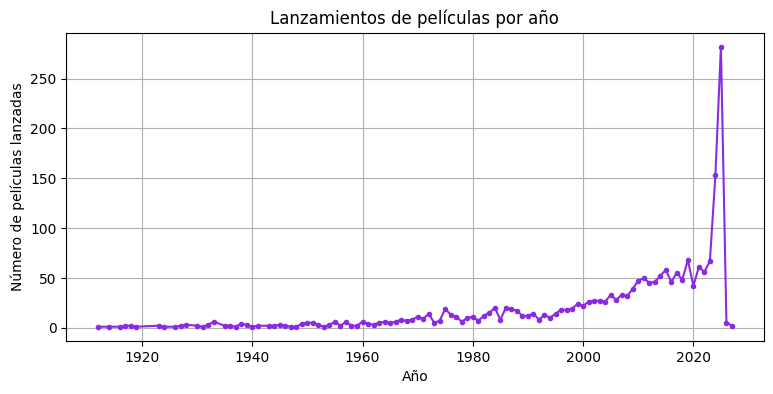

In [14]:
# 3.- ¿cuantas peliculas se lanzaron cada año y cual fue la que mayor presupuesto tenia?

df1['Lanzamiento'] = pd.to_datetime(df1['Lanzamiento'], errors='coerce')
df1['Año'] = df1['Lanzamiento'].dt.year

pelis_por_año = df1['Año'].value_counts().sort_index()

plt.figure(figsize=(9,4))
plt.plot(pelis_por_año.index, pelis_por_año.values, marker='.', color='blueviolet')
plt.xlabel('Año')
plt.ylabel('Número de películas lanzadas')
plt.title('Lanzamientos de películas por año')
plt.grid(True)
plt.show()




El año con más estrenos fue 2025.0 con 282 estrenos.
El año con menos estrenos fue 1912.0 con 1 estrenos.


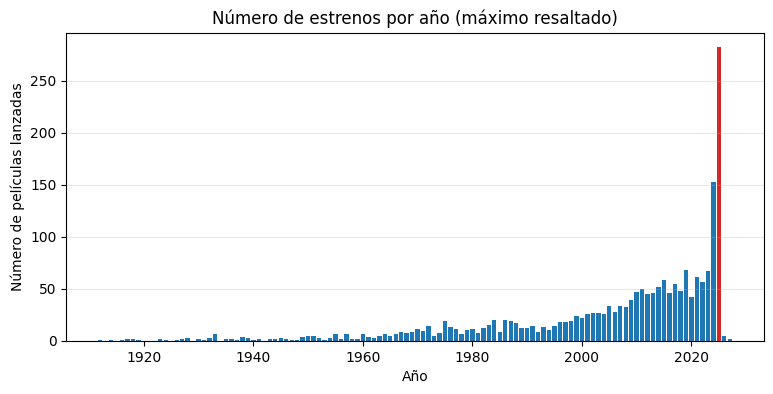

In [15]:
# 4.- ¿cual fue el año con mas estrenos y cual fue el que menos? ¿que genero tuvo mas estrenos?
año_mas_estrenos = pelis_por_año.idxmax()
num_de_estrenos = pelis_por_año.max()

print(f'El año con más estrenos fue {año_mas_estrenos} con {num_de_estrenos} estrenos.')
print(f'El año con menos estrenos fue {pelis_por_año.idxmin()} con {pelis_por_año.min()} estrenos.')

colores = ['C0'] * len(pelis_por_año)
pos_max = list(pelis_por_año.index).index(año_mas_estrenos)
colores[pos_max] = 'C3'

plt.figure(figsize=(9,4))
plt.bar(pelis_por_año.index, pelis_por_año.values, color=colores)
plt.xlabel('Año')
plt.ylabel('Número de películas lanzadas')
plt.title('Número de estrenos por año (máximo resaltado)')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [16]:
# 5- ¿cual es la combinacion de idioma/genero con mejor popularidad promedio?

df_combinaciones = pd.DataFrame(df1[['Titulo', 'Idioma_original', 'Genero', 'Popularidad']])

popularidad_promedio = df_combinaciones.groupby(['Idioma_original', 'Genero'])['Popularidad'].mean().reset_index()

mejor_combinacion = popularidad_promedio.sort_values('Popularidad', ascending=False).head(3)
mejor_combinacion

,Idioma_original,Genero,Popularidad
575,Inglés,"['Drama', 'Terror', 'Fantasía']",485.1768
44,Chino,"['Acción', 'Aventura', 'Fantasía']",356.6402
243,Inglés,"['Acción', 'Aventura', 'Terror']",281.7381


/var/folders/g0/wlz2mvtn4dgf0k5cq1m6vkgr0000gn/T/ipykernel_2559/2305299427.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(generos_usados))


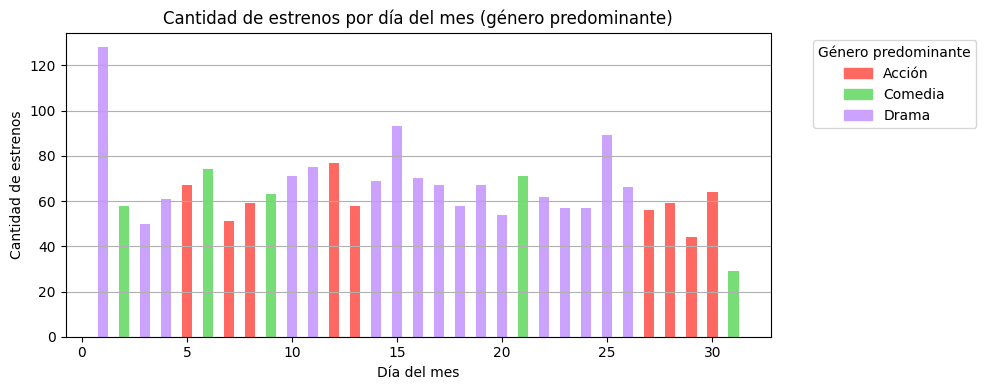

In [17]:
# 6 ¿que dias del mes concentran mas lanzamientos?


df1['Lanzamiento'] = pd.to_datetime(df1['Lanzamiento'], errors='coerce')
df1['Dia_mes'] = df1['Lanzamiento'].dt.day

df1['Genero_principal'] = (
    df1['Genero']
    .astype(str)
    .apply(lambda x: x.strip("[]").split(",")[0].strip(" '") if x not in [None, 'nan', 'None'] else 'Desconocido')
)
df1['Genero_principal'] = df1['Genero_principal'].replace({'nan': 'Desconocido'})

conteo_dias = df1.groupby('Dia_mes').size().sort_index()

genero_dia = df1.groupby('Dia_mes')['Genero_principal'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else 'Desconocido'
)
genero_dia = genero_dia.reindex(conteo_dias.index)

generos_usados = sorted(genero_dia.dropna().unique())
colormap = plt.cm.get_cmap('tab20', len(generos_usados))
color_dict = {gen: colormap(i) for i, gen in enumerate(generos_usados)}

color_dict = {
    'Acción': '#FF6961',
    'Comedia': '#77DD77',
    'Drama': '#CBA3FF',
    'Desconocido': 'gray'
}
colores_barras = genero_dia.map(lambda g: color_dict.get(g, 'black'))

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(conteo_dias.index,
       conteo_dias.values,
       color=colores_barras,
       width=0.5,
       alpha=1.0)

ax.set_title("Cantidad de estrenos por día del mes (género predominante)")
ax.set_xlabel("Día del mes")
ax.set_ylabel("Cantidad de estrenos")
ax.grid(True, axis='y')

handles = [mpatches.Patch(color=color_dict[gen], label=gen) for gen in generos_usados]

ax.legend(handles=handles, title="Género predominante", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()





In [18]:
# 7.- ¿que peliculas tienen votacion mayor de 7 y popularidad mayor de 100?¿

df1['Votacion_media'] = pd.to_numeric(df1['Votacion_media'], errors='coerce')
df1['Popularidad']    = pd.to_numeric(df1['Popularidad'], errors='coerce')

filtro = (df1['Votacion_media'] > 7) & (df1['Popularidad'] > 100)
pelis_top = df1.loc[filtro].copy()

cols = ['Titulo', 'Votacion_media', 'Popularidad', 'Lanzamiento', 'Genero', 'Idioma_original']
cols = [c for c in cols if c in pelis_top.columns]
display(pelis_top[cols])

print(f"Número de películas que cumplen la condición: {len(pelis_top)}")


,Titulo,Votacion_media,Popularidad,Lanzamiento,Genero,Idioma_original
0,Frankenstein,7.8,485.1768,2025-10-17,"['Drama', 'Terror', 'Fantasía']",Inglés
1,Una batalla tras otra,7.5,415.1173,2025-09-23,"['Acción', 'Suspenso', 'Crimen']",Inglés
7,Predator: Badlands,7.4,242.3671,2025-11-05,"['Acción', 'Ciencia ficción', 'Aventura']",Inglés
16,Guardianes de la noche: Kimetsu no Yaiba La fo...,7.6,162.6078,2025-07-18,"['Animación', 'Acción', 'Fantasía', 'Suspenso']",Japonés
18,Chainsaw Man - La película: El arco de Reze,7.8,131.2585,2025-09-19,"['Animación', 'Acción', 'Romance', 'Fantasía']",Japonés
22,En sueños,7.2,107.0771,2025-11-07,"['Animación', 'Familia', 'Comedia', 'Aventura'...",Inglés


Número de películas que cumplen la condición: 6


In [19]:
# 8.- ¿que pelicula ha recaudado mas en taquilla respecto a su presupuesto inicial? ¿ cual menos?

df1['Presupuesto'] = pd.to_numeric(df1['Presupuesto'], errors='coerce')
df1['Taquilla_recaudada'] = pd.to_numeric(df1['Taquilla_recaudada'], errors='coerce')

df_ratio = df1.copy()
df_ratio = df_ratio[(df_ratio['Presupuesto'] > 0) & (df_ratio['Taquilla_recaudada'].notna())]

df_ratio['RETORNO %'] = df_ratio['Taquilla_recaudada'] / df_ratio['Presupuesto']

idx_mejor = df_ratio['RETORNO %'].idxmax()
idx_peor  = df_ratio['RETORNO %'].idxmin()
mejor_peli = df_ratio.loc[idx_mejor, ['Titulo', 'Presupuesto', 'Taquilla_recaudada', 'RETORNO %']]
peor_peli  = df_ratio.loc[idx_peor,  ['Titulo', 'Presupuesto', 'Taquilla_recaudada', 'RETORNO %']]

print("Película con MAYOR recaudación relativa (mejor RETORNO):")
display(mejor_peli.to_frame().T)

print("\nPelícula con MENOR recaudación relativa (peor RETORNO):")
display(peor_peli.to_frame().T)



Película con MAYOR recaudación relativa (mejor RETORNO):


,Titulo,Presupuesto,Taquilla_recaudada,RETORNO %
1978,Easy Rider (Buscando mi destino),400000.0,60000000.0,150.0



Película con MENOR recaudación relativa (peor RETORNO):


,Titulo,Presupuesto,Taquilla_recaudada,RETORNO %
830,Enea,8178032.0,1.0,0.0


In [20]:
# 9.-¿cual es el top 3 de generos que mas recaudan en promedio?

df1['Taquilla_recaudada'] = pd.to_numeric(df1['Taquilla_recaudada'], errors='coerce')

tmp = df1.copy()
tmp['Genero'] = (
    tmp['Genero']
      .astype(str)
      .str.replace('[', '', regex=False)
      .str.replace(']', '', regex=False)
      .str.replace("'", '', regex=False)
      .str.split(',')
)

tmp = tmp.explode('Genero')
tmp['Genero'] = tmp['Genero'].str.strip()

recaudacion_media = (
    tmp.groupby('Genero')['Taquilla_recaudada']
       .mean()
       .sort_values(ascending=False)
)

top3_generos_int = recaudacion_media.head(3).round(0).astype('int64')

top3_generos_formateado = top3_generos_int.map(
    lambda x: f"{x:,}".replace(",", ".") + ' USD'
)

top3_generos_formateado




Genero
Aventura           543.384.543 USD
Ciencia ficción    458.140.758 USD
Fantasía           422.521.124 USD
Name: Taquilla_recaudada, dtype: object

Grafico 1:


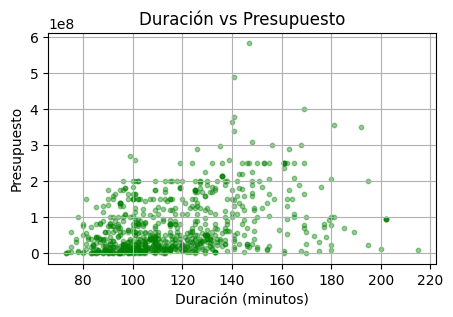

Grafico 2:


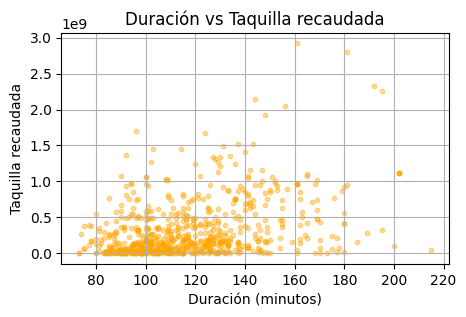

In [21]:
# 10.- ¿ hay coorelacion entre duracion de la pelicula respecto a su presupuesto? y respecto a su taquilla?

df1['Duracion'] = pd.to_numeric(df1['Duracion'], errors='coerce')
df1['Presupuesto'] = pd.to_numeric(df1['Presupuesto'], errors='coerce')
df1['Taquilla_recaudada'] = pd.to_numeric(df1['Taquilla_recaudada'], errors='coerce')

df_plot = df1.dropna(subset=['Duracion','Presupuesto','Taquilla_recaudada'])


print('Grafico 1:')

plt.figure(figsize=(5,3))
plt.scatter(df_plot['Duracion'], df_plot['Presupuesto'], alpha=0.4, s=10, color='green')
plt.title('Duración vs Presupuesto')
plt.xlabel('Duración (minutos)')
plt.ylabel('Presupuesto')
plt.grid(True)
plt.show()

print('Grafico 2:')

plt.figure(figsize=(5,3))
plt.scatter(df_plot['Duracion'], df_plot['Taquilla_recaudada'], alpha=0.4, s=10 , color='orange')
plt.title('Duración vs Taquilla recaudada')
plt.xlabel('Duración (minutos)')
plt.ylabel('Taquilla recaudada')
plt.grid(True)
plt.show()
